In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [32]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:]

aux.shape, targets.shape, run_path

((1160, 5), (1160, 22), '/media/beans/ssd/blender_membank/dataloader_09/run_1')

In [33]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

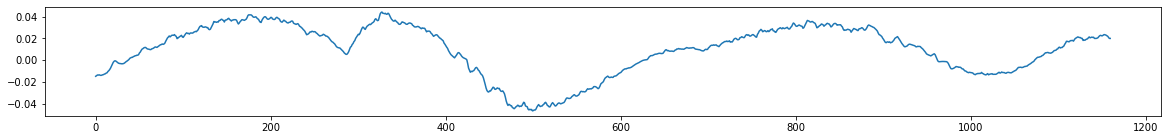

In [34]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

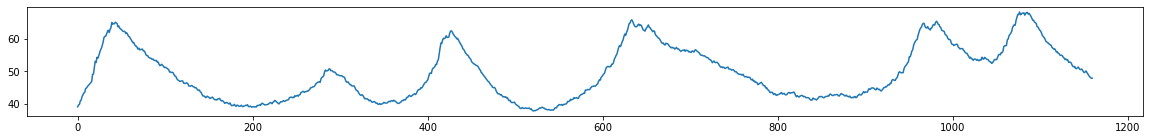

In [35]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

<BarContainer object of 10 artists>

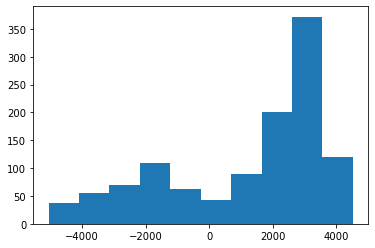

In [36]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

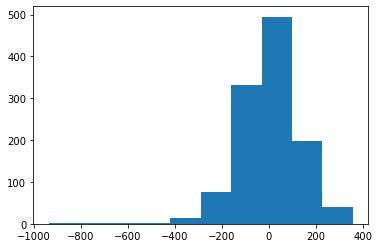

In [37]:
plt.hist(torque[1:]-torque[:-1])[2]

In [38]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [39]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [19]:
all_aux = []
all_targets = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        all_aux.append(aux)
        all_targets.append(targets)
        
all_aux = np.stack(all_aux, axis=0)
all_targets = np.stack(all_targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 14 out of 360 runs


In [20]:
all_aux.shape

(346, 1160, 5)

In [21]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_targets[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

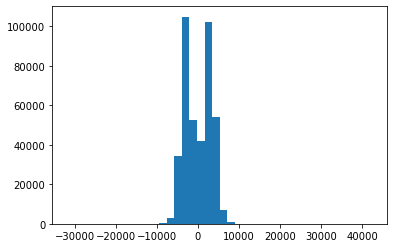

In [22]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

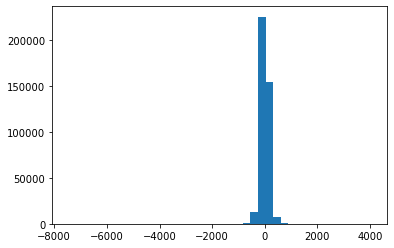

In [23]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [24]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(727.5166342192025, 8577.985823860767)

In [25]:
all_targets.shape

(346, 1160, 22)

In [26]:
mean_angles = abs(all_targets).mean(axis=0).mean(0)
mean_angles

array([0.02088495, 0.02420391, 0.02758232, 0.03097461, 0.03436409,
       0.03774305, 0.0411077 , 0.0444566 , 0.04778814, 0.05110184,
       0.05439718, 0.05767357, 0.06093033, 0.06416698, 0.06738364,
       0.07058018, 0.07375593, 0.07691126, 0.0800455 , 0.08315899,
       0.08625122, 0.08932196], dtype=float32)

In [27]:
mean_angles[-1] / mean_angles[0]

4.2768574

<BarContainer object of 40 artists>

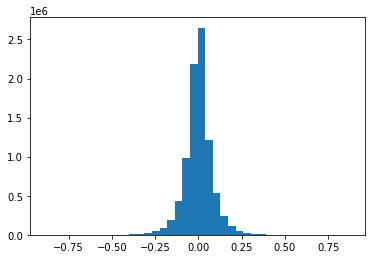

In [28]:
plt.hist(all_targets.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

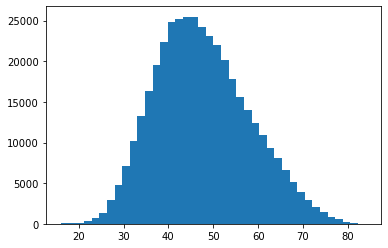

In [29]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

In [30]:
all_targets.min()

-0.8834208